In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder, Normalizer, Binarizer
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


NAMA: MUHAMMAD RIDAFFA PURNOMO



NIM: 1301174224

In [2]:
%cd /content/drive/My Drive/dataset_damin/

/content/drive/My Drive/dataset_damin


# Task
Buat model untuk mengklasifikasi transaksi fraud atau tidak fraud
Terdapat dua file “train.csv” dan “test.csv” yang fitur-fiturnya identical.
File train.csv berisi data untuk melatih model klasifikasi, dan file test.csv digunakan untuk mencari prediksi fraud-nya
Kolom fraud berisi dua kemungkinan integer, (0,1)


In [4]:
train = pd.read_csv('train.csv', delimiter="|")
df = train.copy()
test = pd.read_csv('test.csv', delimiter="|")
data_test = test.copy()
df.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [5]:
data_test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526


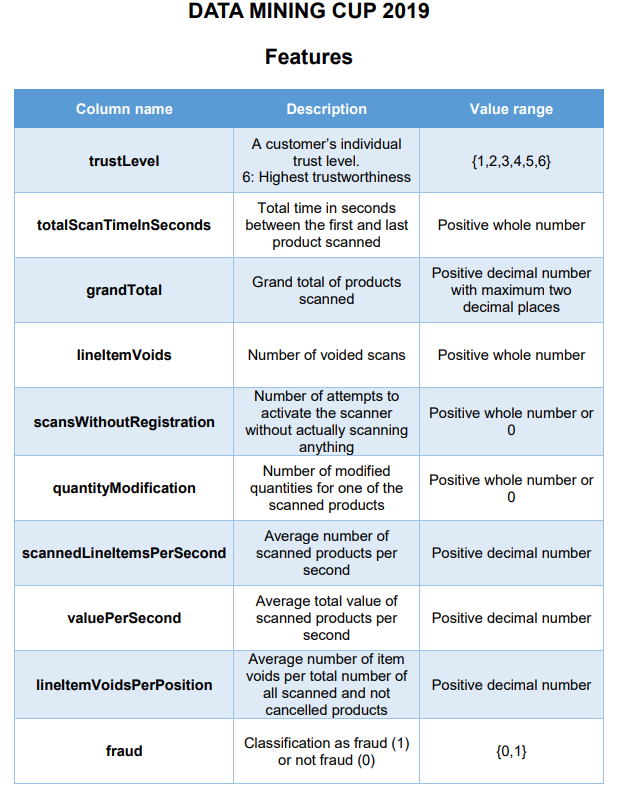

# Data Analisis


Periksa Apakah ada data yang *null* atau kosong

In [6]:
print(df.isnull().values.any())
print(data_test.isnull().values.any())

False
False


Tipe data pada data train

In [7]:
df.dtypes

trustLevel                     int64
totalScanTimeInSeconds         int64
grandTotal                   float64
lineItemVoids                  int64
scansWithoutRegistration       int64
quantityModifications          int64
scannedLineItemsPerSecond    float64
valuePerSecond               float64
lineItemVoidsPerPosition     float64
fraud                          int64
dtype: object

Distribusi data terhadap *fraud*

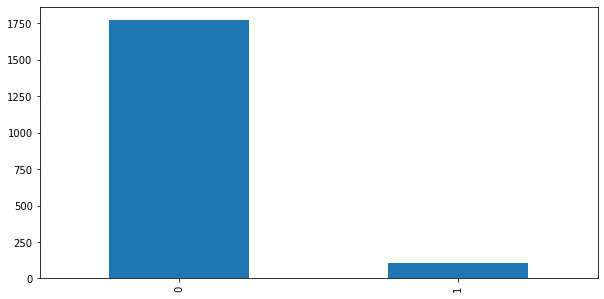

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['fraud'].value_counts().plot(kind='bar', ax=ax1)
plt.show() 

Korelasi antar fitur terhadap fraud

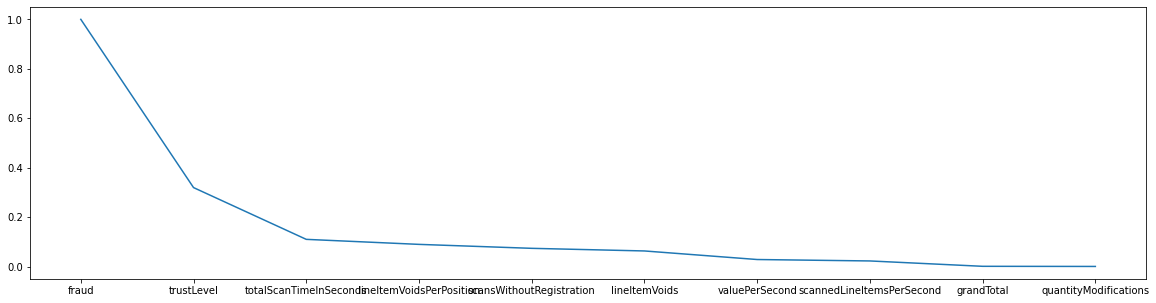

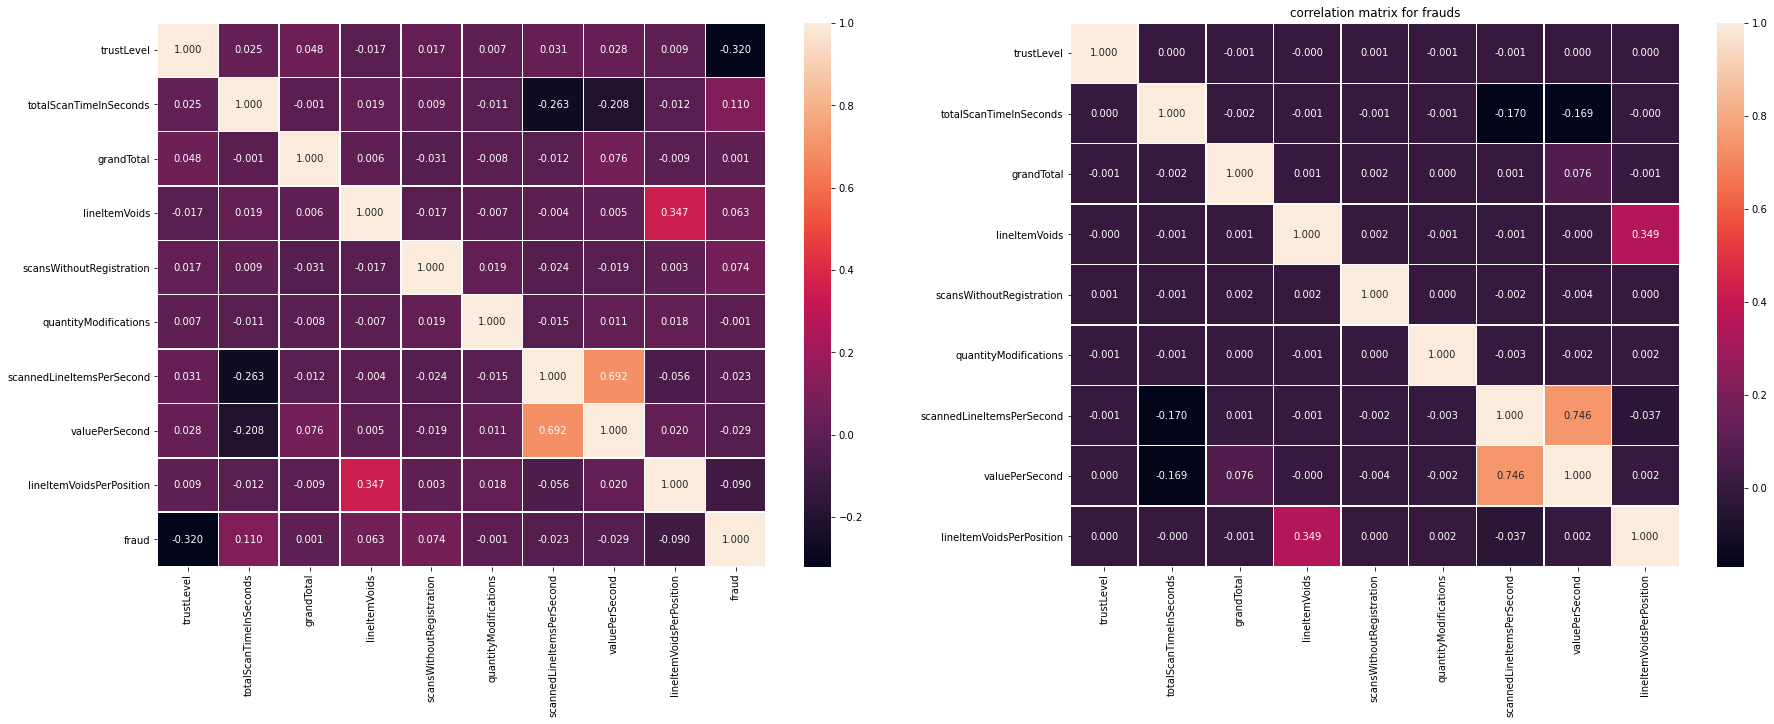

fraud                        1.000000
trustLevel                   0.319765
totalScanTimeInSeconds       0.110414
lineItemVoidsPerPosition     0.090116
scansWithoutRegistration     0.074123
lineItemVoids                0.063496
valuePerSecond               0.028873
scannedLineItemsPerSecond    0.023085
grandTotal                   0.001421
quantityModifications        0.000864
Name: fraud, dtype: float64


In [9]:
numeric_features = df.select_dtypes(include=[np.number])
numeric_features.columns
correlation = numeric_features.corr()
korelasi = correlation['fraud'].sort_values(ascending = False)
for i in range(len(korelasi)):
  if(korelasi[i] < 0):
    korelasi[i]  = korelasi[i]  * (-1)
plt.figure(figsize=(20,5))
plt.plot(korelasi.sort_values(ascending = False))
korelasi = korelasi.sort_values(ascending = False)
f,ax = plt.subplots(figsize=(30, 10), ncols=2)
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.3f',ax=ax[0])
sns.heatmap(data_test.corr(), annot=True, linewidths=.5, fmt= '.3f',ax=ax[1])

plt.title("correlation matrix for frauds")
plt.show()
print(korelasi)


# Feature Engineering
Menambahkan 1 fitur



totalItem = totalScanTimeInSeconds x scannedLineItemsPerSecond 


Fitur ini ditambahkan karena memiliki korelasi yang tinggi terhadap fraud

fraud                        1.000000
trustLevel                   0.319765
totalItem                    0.298423
totalScanTimeInSeconds       0.110414
lineItemVoidsPerPosition     0.090116
scansWithoutRegistration     0.074123
lineItemVoids                0.063496
valuePerSecond               0.028873
scannedLineItemsPerSecond    0.023085
grandTotal                   0.001421
quantityModifications        0.000864
Name: fraud, dtype: float64


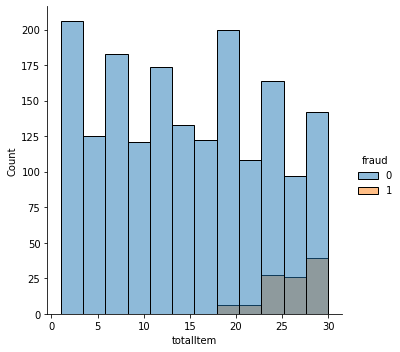

In [10]:

df['totalItem'] = train.totalScanTimeInSeconds * train.scannedLineItemsPerSecond
# df['valuePerItem'] = train.valuePerSecond / df.scannedLineItemsPerSecond
# df['total_item'] = df.total_item - (train.scansWithoutRegistration * train.scannedLineItemsPerSecond)
# df['fet1'] =  (train.lineItemVoids * train.lineItemVoidsPerPosition)
# df['fet1'] =  (train.totalScanTimeInSeconds * train.valuePerSecond)


data_test['totalItem'] = test.totalScanTimeInSeconds * test.scannedLineItemsPerSecond
# data_test['valuePerItem'] = test.valuePerSecond / data_test.scannedLineItemsPerSecond
# data_test['total_item'] = test.totalScanTimeInSeconds * test.scannedLineItemsPerSecond
# data_test['total_item'] = data_test.total_item - (test.scansWithoutRegistration * test.scannedLineItemsPerSecond)

# sns.displot(df, x="total_item", hue="fraud")
numeric_features = df.select_dtypes(include=[np.number])
numeric_features.columns
correlation = numeric_features.corr()
korelasi = correlation['fraud'].sort_values(ascending = False)
for i in range(len(korelasi)):
  if(korelasi[i] < 0):
    korelasi[i]  = korelasi[i]  * (-1)
korelasi = korelasi.sort_values(ascending = False)
sns.displot(df, x="totalItem", hue="fraud")
print(korelasi)

Bisa dibilang untuk totalItem < 20 merupakan transaksi tidak fraud, model pun akan lebih optimal berlatih pada data train

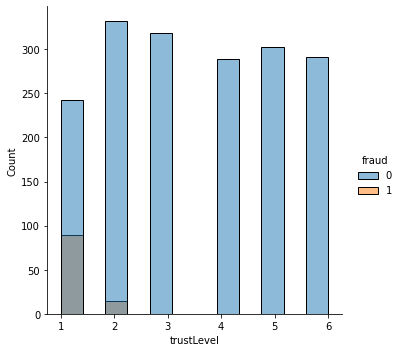

In [11]:
sns.displot(df, x="trustLevel", hue="fraud")

Maka mendapat pola untuk trustLevel > 2 | fraud = (0), trustLevel <=2  | fraud = (0,1)

Terlihat korelasi trustLevel paling tinggi yaitu 0.319765, sekarang kita lihat distribusinya
Sama seperti sebelumnya, untuk trustLevel > 2 merupakan transaksi tidak fraud, dengan demikian model bisa lebih optimal lagi berlatih pada data train.


# Rancangan Sistem



In [12]:
# df_new = df[df.trustLevel <=2 ]
# df_new

Untuk melatih model, kita harus membagi data train menjadi X sebagai fitur dan y sebagai label

In [13]:
X, y = df.loc[:, df.columns != 'fraud'], df.fraud

In [13]:
# scaler = StandardScaler()
# scaler = scaler.fit(X)
# X = scaler.transform(X)

In [14]:
X.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,totalItem
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,29.0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,14.0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,13.0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,29.0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,27.0


X dan y kita bagi lagi menjadi data train dan data validation

a.	Data train
Data yang digunakan untuk melatih model machine learning, model akan melihat dan belajar dari data ini.



b.	Data Validation
Data validation digunakan untuk mengevaluasi model, data ini tidak digunakan model untuk belajar, namun data ini digunakan untuk memperbarui parameter pada model agar lebih optimal


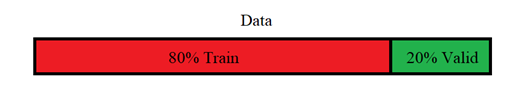

In [15]:
X_train_o, X_valid_o, y_train_o, y_valid_o = train_test_split(X, y, test_size=0.2, random_state=13)

Data yang diberikan sangat tidak balance atau imbalance. Data imbalance sangat mempengaruhi model belajar, data ini akan mempengaruhi kinerja model yang akan dibuat. Klasifikasi yang dilakukan akan membuat model belajar secara bias, sehingga akurasi pada kelas minoritas akan lebih kecil dibanding kelas mayoritas. Oleh karena itu, akan dilakukan oversampling pada data train. Oversampling adalah metode untuk menduplikasi kelas minoritas sampai berukuran sama dengan atau mendekati ukuran kelas mayoritas

Metode oversampling yang digunakan adalah Synthetic Minority Oversampling Technique (SMOTE). Cara kerjanya yaitu dengan memilih salah satu data pada kelas minoritas, kemudian k dari tetangga terdekat dipilih secara acak menjadi sample baru. Prosedur ini terus berulang sampai kelas minoritas berukuran sama dengan kelas mayoritas.

In [16]:
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, SVMSMOTE, BorderlineSMOTE, BorderlineSMOTE, SMOTENC
# oversample = SMOTENC(random_state=42, categorical_features=[0,2,3])
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train_o, y_train_o)
# X_train, y_train = X_train_o, y_train_o

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


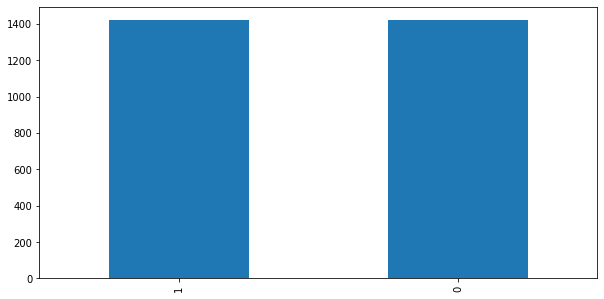

In [17]:
# fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
# y_train.value_counts.plot(kind='bar', ax=ax1)
# plt.show()
fraud_df_train = pd.DataFrame(data=y_train, columns=['fraud'])
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
fraud_df_train.fraud.value_counts().plot(kind='bar', ax=ax1)
plt.show()

In [18]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC,LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,ExtraTreesClassifier,StackingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier, BalancedBaggingClassifier
from sklearn.pipeline import make_pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24

Setelah itu kita inisialisasi model klasifikasi apa saja yang akan kita coba, di sini penulis menggunakan.
1.	K-Nearest Neighbors
2.	Support Vector Machine (SVM)
3.	Linear SVC
4.	Decision Tree
5.	Random Forest
6.	AdaBoost
7.	GradientBoost
8.	Naïve Bayes
9.	Balance Bagging
10.	RUSBoost
11.	Linear Discriminant Analysis
12.	Quadratic Discriminant Analysis


In [19]:
estimators = [
('gbc', GradientBoostingClassifier(random_state=42)),
('svr', SVC(gamma='auto', kernel='linear', C=0.5, random_state=5))
]
classifiers = [
    KNeighborsClassifier(5),
    SVC(gamma='auto', kernel='linear', C=0.3),
    LinearSVC(random_state=42),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(),
    # ExtraTreesClassifier(),
    # StackingClassifier(estimators=estimators, final_estimator=AdaBoostClassifier()),
    GaussianNB(),
    BalancedBaggingClassifier(random_state=42),
    RUSBoostClassifier(random_state=0),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()
]

Dari beberapa model klasifikasi tersebut, kita coba latih satu persatu ke data train, dan dapatkan laporan klasifikasi dari prediksi data validation.

In [20]:
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)
target_names = list(df['fraud'].unique())
for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_valid_o)
    acc = accuracy_score(y_valid_o, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    print(classification_report(y_valid_o.to_numpy().ravel(), train_predictions, labels=target_names))
    if name != 'SVC' and name != 'VotingClassifier' and name != 'LinearSVC':
      train_predictions = clf.predict_proba(X_valid_o)
    
    ll = log_loss(y_valid_o, train_predictions)
    print("Log Loss: {}".format(ll))
    
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 73.4043%
              precision    recall  f1-score   support

           0       0.95      0.75      0.84       352
           1       0.11      0.46      0.18        24

    accuracy                           0.73       376
   macro avg       0.53      0.61      0.51       376
weighted avg       0.90      0.73      0.80       376

Log Loss: 3.4008739511109503
SVC
****Results****
Accuracy: 99.4681%
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       352
           1       0.92      1.00      0.96        24

    accuracy                           0.99       376
   macro avg       0.96      1.00      0.98       376
weighted avg       1.00      0.99      0.99       376

Log Loss: 0.18372114889543115
LinearSVC
****Results****
Accuracy: 78.4574%
              precision    recall  f1-score   support

           0       1.00      0.77      0.87       352
           1       0.22      0.96     

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RandomForestClassifier
****Results****
Accuracy: 98.4043%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       352
           1       0.88      0.88      0.88        24

    accuracy                           0.98       376
   macro avg       0.93      0.93      0.93       376
weighted avg       0.98      0.98      0.98       376

Log Loss: 0.04366538840095381
AdaBoostClassifier
****Results****
Accuracy: 99.7340%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       352
           1       0.96      1.00      0.98        24

    accuracy                           1.00       376
   macro avg       0.98      1.00      0.99       376
weighted avg       1.00      1.00      1.00       376

Log Loss: 0.3010022684668971
GradientBoostingClassifier
****Results****
Accuracy: 98.6702%
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       352
    

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

LinearDiscriminantAnalysis
****Results****
Accuracy: 87.7660%
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       352
           1       0.34      1.00      0.51        24

    accuracy                           0.88       376
   macro avg       0.67      0.93      0.72       376
weighted avg       0.96      0.88      0.90       376

Log Loss: 0.25336370185936197
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 94.1489%
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       352
           1       0.52      0.96      0.68        24

    accuracy                           0.94       376
   macro avg       0.76      0.95      0.82       376
weighted avg       0.97      0.94      0.95       376

Log Loss: 0.508410223995269


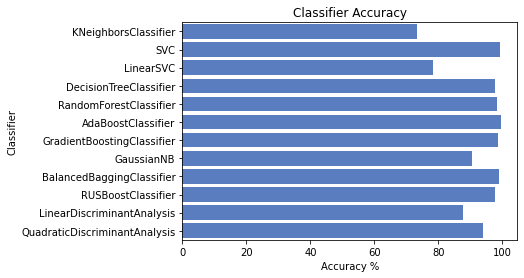

In [21]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
sns.set(rc={'figure.figsize':(5,10)})
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

# sns.set_color_codes("muted")
# sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

# plt.xlabel('Log Loss')
# plt.title('Classifier Log Loss')
# plt.show()

Dengan demikian, kita mendapat 3 metode kelasifikasi terbaik, yaitu :
1.	SVM
2.	AdaBoost
3.	GradientBoost


Selanjutnya kita gabungkan ketiga model tersebut menggunakan Stacking Classifier

Model Stacking Classifier kemudian dilatih dengan data train dan diuji dengan data validation. 

In [22]:
from sklearn.model_selection import KFold
model = StackingClassifier(estimators=estimators, final_estimator=AdaBoostClassifier(random_state=5))
model.fit(X_train, y_train)
print('****Results****')
train_predictions = model.predict(X_valid_o)
acc = accuracy_score(y_valid_o, train_predictions)
print("Accuracy: {:.4%}".format(acc))
print(classification_report(y_valid_o.to_numpy().ravel(), train_predictions, labels=target_names))
# kf = KFold(n_splits=10, random_state=1)
# kf.get_n_splits(X)
# for train_index, test_index in kf.split(X):
#   # print("TRAIN:", train_index, "TEST:", test_index)
#   X_train, X_test = X[train_index], X[test_index]
#   y_train, y_test = y[train_index], y[test_index]
#   model.fit(X_train, y_train)
#   print('****Results****')
#   train_predictions = model.predict(X_test)
#   acc = accuracy_score(y_test, train_predictions)
#   print("Accuracy: {:.4%}".format(acc))
#   # print(classification_report(y_test.to_numpy().ravel(), train_predictions, labels=target_names))
#   # train_predictions = model.predict_proba(X_test)
#   ll = log_loss(y_test, train_predictions)
#   print("Log Loss: {}".format(ll))
  


****Results****
Accuracy: 100.0000%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       352
           1       1.00      1.00      1.00        24

    accuracy                           1.00       376
   macro avg       1.00      1.00      1.00       376
weighted avg       1.00      1.00      1.00       376



In [23]:
X_test = data_test

# Evaluasi Model
Kemudian, dilakukan prediksi pada data test menggunakan model Stacking Classifier yang sudah dilatih sebelumnya.


In [24]:
predict_test = model.predict(X_test)


Dikarenakan saat penulis membuat model, sudah terdapat solusi untuk data test ini. Maka dari itu, kita bisa mencari akurasi model terhadap data¬ test ini.



In [25]:
real_class = pd.read_csv('DMC-2019-realclass.csv', delimiter="|")
real_class.head()

,fraud
0,0
1,0
2,0
3,0
4,0


Setelah memprediksi data test dan dibandingkan dengan solusi yang ada, hasilnya sebagai berikut.

In [26]:
print(classification_report(real_class.to_numpy().ravel(), predict_test.ravel(), labels=target_names))
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
print_confusion_matrix(real_class.to_numpy().ravel(), predict_test.ravel())

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    474394
           1       0.90      0.91      0.90     23727

    accuracy                           0.99    498121
   macro avg       0.95      0.95      0.95    498121
weighted avg       0.99      0.99      0.99    498121

True positive =  471890
False positive =  2504
False negative =  2224
True negative =  21503
